In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox


In [12]:
df = pd.read_csv('./../data/live/7y_up_to_4_17_2025_news.csv', parse_dates=['date'], index_col='date')

In [72]:
df.head()

,date.1,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,...,overall_pos_count,overall_neg_count,vix_target,mean_sentiment_decay,shock_pos,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore
date,,,,,,,,,,,,,,,,,,,,,
2017-12-13,2017-12-13,0.086767,0.086767,0.086767,2,0,-0.533592,-0.533592,-0.533592,0,...,2,2,10.18,0.061505,-0.223413,-0.223413,2,0,-0.014521,-0.506566
2017-12-14,2017-12-14,0.091055,0.091055,0.091055,1255,0,0.091055,0.091055,0.091055,1255,...,2510,0,10.49,-0.223413,0.091055,0.091055,1255,0,0.040675,-0.192338
2017-12-26,2017-12-26,0.090923,0.090923,0.090923,1,0,0.090923,0.090923,0.090923,1,...,2,0,10.25,0.091055,0.090923,0.090923,1,0,0.066597,-0.357704
2017-12-27,2017-12-27,0.505010,0.060151,0.949869,2,0,0.086224,0.082667,0.089780,2,...,4,0,10.47,0.090923,0.519825,0.071409,2,0,0.056509,-0.015066
2018-01-02,2018-01-02,0.065905,0.065905,0.065905,1,0,0.085878,0.085878,0.085878,1,...,2,0,9.77,0.295617,0.075892,0.075892,1,0,-0.117434,-0.890572


In [81]:
vix = df['vix_target']
returns = np.log(vix).diff().dropna()


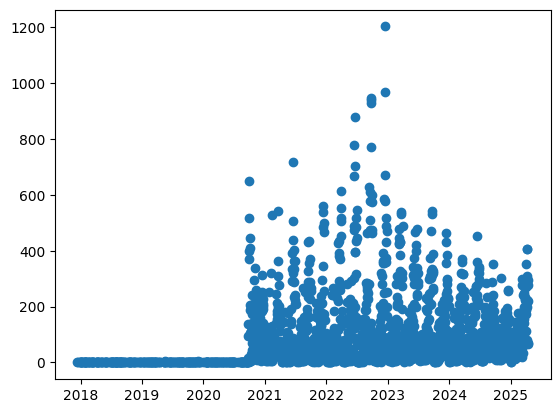

In [90]:
plt.scatter(df.index,df['overall_neg_count'])

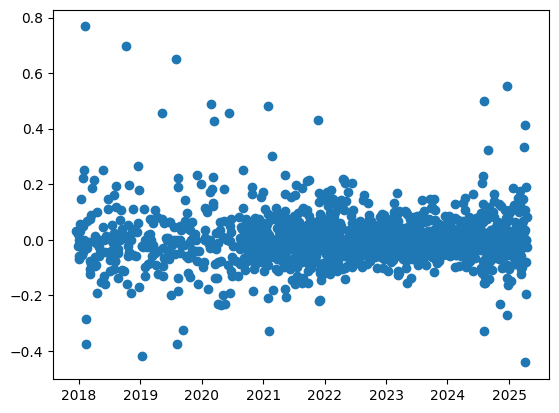

In [88]:
plt.scatter(df.index[1:],returns)

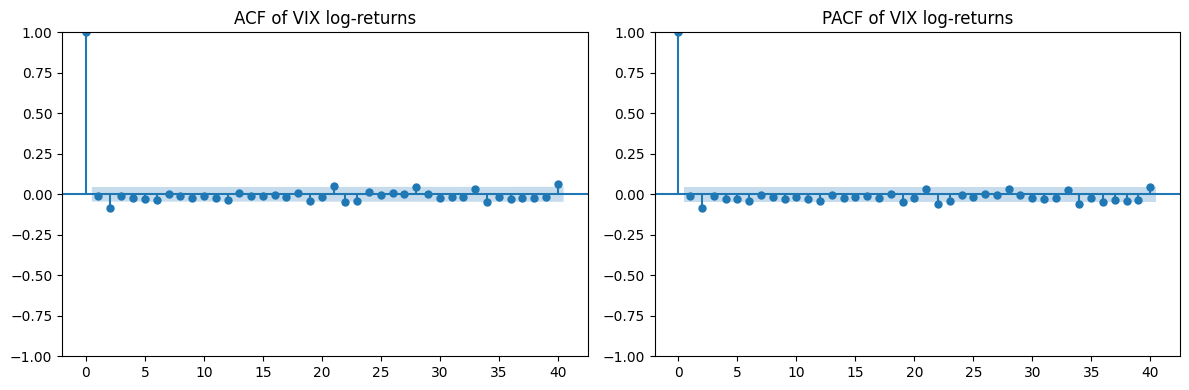

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(returns, lags=40, ax=axes[0])
axes[0].set_title('ACF of VIX log-returns')
plot_pacf(returns, lags=40, ax=axes[1])
axes[1].set_title('PACF of VIX log-returns')
plt.tight_layout()
plt.show()

In [23]:
arima = ARIMA(returns, order=(1,0,1)).fit()
resid = arima.resid

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [24]:
scaled_resid = resid * 100

eg = arch_model(scaled_resid, vol='EGARCH', p=1, q=1, dist='t')
eg_res = eg.fit(disp='off')

print(eg_res.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -5979.35
Distribution:      Standardized Student's t   AIC:                           11968.7
Method:                  Maximum Likelihood   BIC:                           11996.5
                                              No. Observations:                 1903
Date:                      Mon, Apr 28 2025   Df Residuals:                     1902
Time:                              10:06:43   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

In [25]:
std_resid = eg_res.std_resid
sq_resid  = std_resid**2

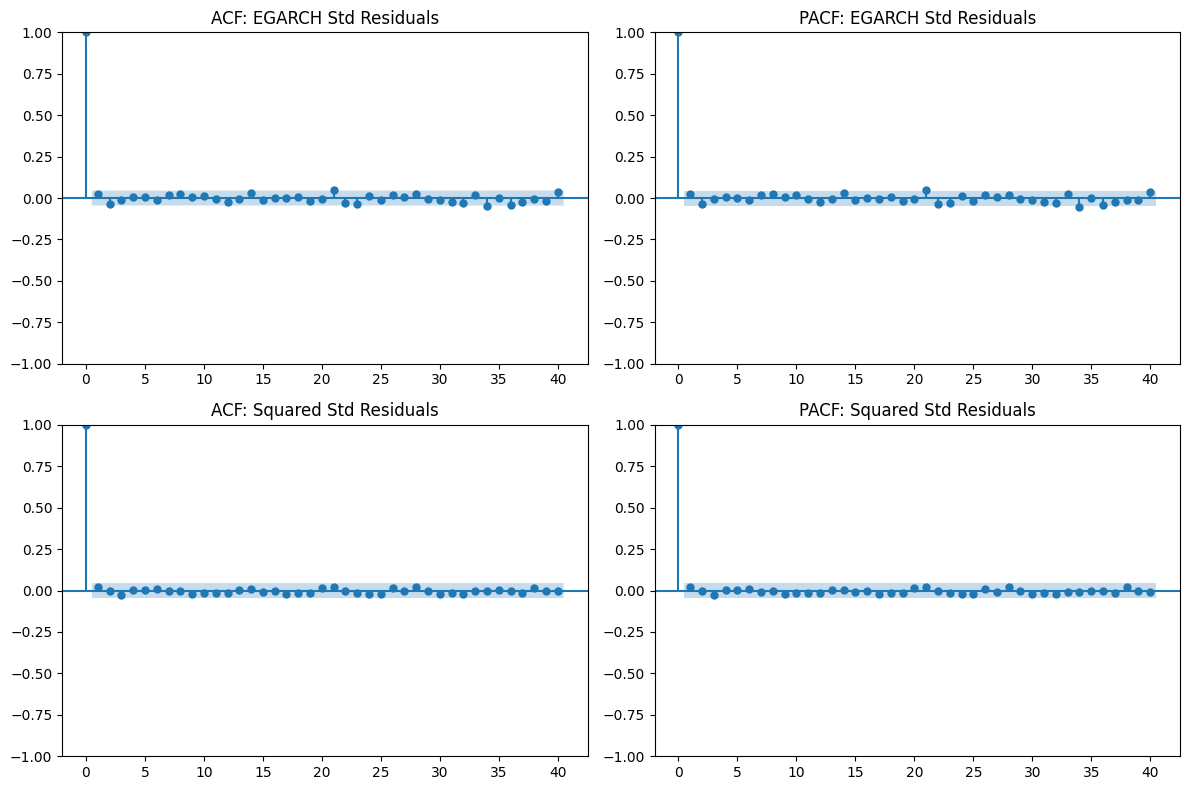

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))

plot_acf(std_resid, lags=40, ax=axes[0,0])
axes[0,0].set_title('ACF: EGARCH Std Residuals')

plot_pacf(std_resid, lags=40, ax=axes[0,1])
axes[0,1].set_title('PACF: EGARCH Std Residuals')

plot_acf(sq_resid, lags=40, ax=axes[1,0])
axes[1,0].set_title('ACF: Squared Std Residuals')

plot_pacf(sq_resid, lags=40, ax=axes[1,1])
axes[1,1].set_title('PACF: Squared Std Residuals')

plt.tight_layout()
plt.show()

In [27]:
orders = [(1,1), (1,2), (2,1), (2,2)]

results = []

for p, q in orders:
    print(f"\n=== Fitting EGARCH({p},{q}) ===")
    eg = arch_model(resid * 100, vol='EGARCH', p=p, q=q, dist='t')
    res = eg.fit(disp='off')
    print(res.summary().tables[1])      # just show the volatility parameters
    
    # Standardized & squared residuals
    sr = res.std_resid
    sq = sr**2
    
    # Ljung-Box on squared resid (vol clustering check)
    lb = acorr_ljungbox(sq, lags=[10], return_df=True)
    lb_p = lb['lb_pvalue'].iloc[0]
    
    # Record AIC/BIC and LB p-value
    results.append({
        'order': (p,q),
        'AIC': res.aic,
        'BIC': res.bic,
        'LB_pval_sq': lb_p
    })
    
# 2) Summarize
import pandas as pd
pd.DataFrame(results).sort_values('AIC')



=== Fitting EGARCH(1,1) ===
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.7674  8.231e-02     -9.323  1.131e-20 [ -0.929, -0.606]

=== Fitting EGARCH(1,2) ===
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.7556  8.124e-02     -9.300  1.404e-20 [ -0.915, -0.596]

=== Fitting EGARCH(2,1) ===
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.7123  8.471e-02     -8.409  4.136e-17 [ -0.878, -0.546]

=== Fitting EGARCH(2,2) ===
        

,order,AIC,BIC,LB_pval_sq
2,"(2, 1)",11948.446030,11981.753151,0.900488
3,"(2, 2)",11950.446031,11989.304339,0.900394
1,"(1, 2)",11962.492571,11995.799692,0.977498
0,"(1, 1)",11968.708211,11996.464145,0.970657


actual models

In [42]:
arima_order = (1,0,1)
garch_order = (2,1)
dist        = 't'
steps       = 60
n_paths     = 500
threshold   = 35

In [43]:
S0 = vix.iloc[-1]
returns = np.log(vix).diff().dropna()


In [44]:
arima = ARIMA(returns, order=arima_order).fit()
resid = arima.resid * 100
eg = arch_model(resid, vol='EGARCH', p=garch_order[0], q=garch_order[1], dist=dist)
eg_res= eg.fit(disp='off')

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


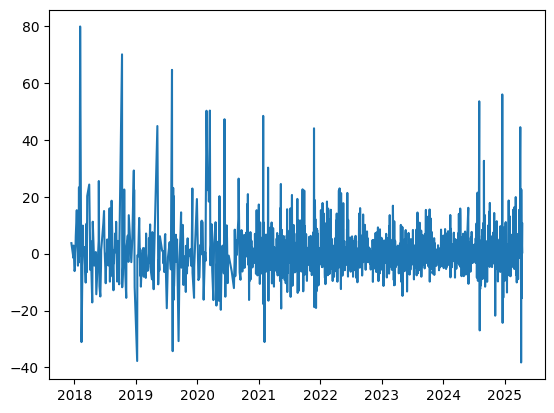

In [70]:
plt.plot(eg_res.resid)

In [64]:
paths = np.zeros((n_paths, steps+1))
paths[:, 0] = S0

MAX_RETURN = 0.20
MIN_RETURN = -0.20
log_S0 = np.log(S0)

for i in range(n_paths):
    arima_sim = arima.simulate(nsimulations=steps, initial=returns.iloc[-1])
    garch_sim = eg.simulate(params=eg_res.params, nobs=steps)
    garch_rets = garch_sim['data'][:steps] / 100

    combined_rets = np.array(arima_sim) + np.array(garch_rets)
    combined_rets = np.clip(combined_rets, MIN_RETURN, MAX_RETURN)

    log_levels = log_S0 + np.cumsum(combined_rets)
    levels = np.exp(log_levels)

    paths[i, 1:] = np.clip(levels, 0, 100)




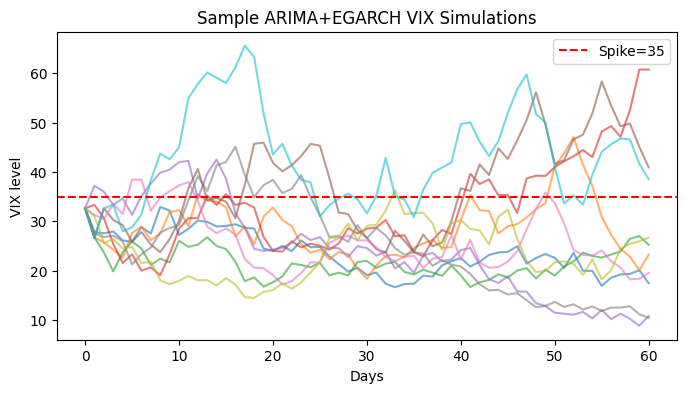

In [65]:
plt.figure(figsize=(8,4))
for i in range(10):
    plt.plot(paths[i], alpha=0.6)
plt.axhline(threshold, color='r', linestyle='--', label=f'Spike={threshold}')
plt.title('Sample ARIMA+EGARCH VIX Simulations')
plt.xlabel('Days')
plt.ylabel('VIX level')
plt.legend()
plt.show()